# Exercice 12) Deep Deterministic Policy Gradients and Proximal Policy Optimization

In this exercise we will investigate two state-of-the-art algorithms for handling a continuous control set: deep deterministic policy gradient (DDPG) and proximal policy optimization (PPO).

We will examine their performance on [Goddard's rocket problem](https://github.com/osannolik/gym-goddard).
This environment comes prepackaged in this notebook's folder, so it can be easily imported.

```
First formulated by R. H. Goddard around 1910, this is a classical problem within dynamic optimization and optimal control. The task is simply to find the optimal thrust profile for a vertically ascending rocket in order for it to reach the maximum possible altitude, given that its mass decreases as the fuel is spent and that it is subject to varying drag and gravity.
```

The gym's observation space is the rocket's vertical position, velocity and mass, which are already normalized to the range $[0, 1]$.

The rocket engine is assumed to be throttled such that the thrust can be continuously controlled between 0 up to its maximum limit, which translates to an action space $\mathcal U \in [0, 1]$.

During the episode the reward is set to $r=0$.
When the episode is terminating, the (normalized) maximum altitude reached by the rocket during the experiment is used as reward.
If the rocket has not depleted its tank after $300$ steps, a reward of $r=-1$ is applied and the episode terminates.

![](rocket_spacex.jpg)
(Photo by <a href="https://unsplash.com/@spacex?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">SpaceX</a> on <a href="https://unsplash.com/s/photos/rocket?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>)
  

In order for the full notebook to run through, you will also need the stable-baslines3 package.

```
pip install stable-baselines3[extra]
```

In [1]:
from rocket_env import GoddardEnv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from stable_baselines3 import PPO, DDPG, A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from copy import deepcopy

OPTIMAL_CONTROL = 0.0122079818367078
RANDOM_AVG = 0.00995
RANDOM_BEST = 0.01148

## 1) DDPG

Deep Deterministic Policy Gradient (DDPG) was first introduced [2015](https://arxiv.org/abs/1509.02971).
It uses four neural networks to operate on the continuous state and action space.
The first two we already know from the last exercise introduced Actor-Critic method: a critic to estimate the q-value function and a (now deterministic) actor which - once completely trained - should give us the best action for a specific state with respect to the q-value function.
Additionally, DDPG provides two target networks which are (in the beginning) copies of the actor and critic. These target networks are updated time-delayed in a low-pass filter manner.
This enhances stability during the learning process because the networks used to calculate the target are not directly updated on the fly.
For more information see the example [here](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).

During the learning process, the critic is updated based on minimizing (!) the following loss function (```critic_loss```):

\begin{equation}
\mathcal L(w, {\mathcal D}) = \underset{(x,u,r,x',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg(  \left(r + \gamma \hat{q}_{}(x',\mu(x', \theta^-), w^-) \right) - \hat{q}(x,u, w) \Bigg)^2
    \right].
\end{equation}   

Here, the target is calculated using the target networks. $w$ and $w^-$ are the parameters of the critic and critic-target networks $\hat{q}$, respectively $\theta$ and $\theta^-$ define the parameters of the actor and actor-target networks.

The policy / actor network is updated to maximize (!) the expected return (```actor_loss```)

\begin{align}
    \max_{\theta} \underset{x \sim {\mathcal D}}{{\mathrm E}}\left[\hat{q}(x, \mu_{}(x, \theta), w) \right],
\end{align}  

where $\theta$ is the set of parameters of the policy network $\mu$.

The updates are performed off-policy by sampling from an experience replay buffer ${\mathcal D}$.
Since we are dealing with a deterministic actor, exploration during training must be explicitly considered by the user. It is usually achieved by adding noise to the sampled actions.

### Task: Implement the DDPG with PyTorch
Write a DDPG algorithm using the Algo. 12.2 in lecture 12! Figure 12.2 might also be helpful to understand the structure of the algorithm.
A lot of the functions and classes are already defined to help you out.

Execute the following cell to make use of the defined multi layer perceptron and the plot function!

In [3]:
def mlp(sizes, activation, output_activation=nn.Identity):
    """Defines a multi layer perceptron using pytorch layers and activation funtions.

    Args:
        sizes: The sizes of all the network layers. This includes the input and output layers.
        activation: The activation function for the hidden layers
        output_action: The activation function for the output layer

    Returns:
        The multilayer-perceptron PyTorch model
    """
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def plot_reward_trends(logs):
    """Plots the reward curves for different training runs based on the trainings logs."""
    repeats = len(logs['envs'])
    ncols = 2
    nrows = int(np.ceil(repeats / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*4), sharex=True, sharey=True)
    for ax, _env, _model in zip(axes.flatten(), logs['envs'], logs['models']):
        ax.plot(_env.get_episode_rewards(), label='rewards', color='green')

        ax.set_ylabel('Reward')
        ax.set_xlabel('Episode')
        ax.set_ylim(0, 0.015)
        ax.axhline(OPTIMAL_CONTROL, ls='--', color='red', label='optimal')
        ax.axhline(RANDOM_BEST, ls='--', color='orange', label='best rnd actions')
        ax.axhline(RANDOM_AVG, ls='--', color='yellow', label='average rnd actions')
        ax.legend(loc='lower left')
        ax2 = ax.twinx()
        ax2.plot(_env.get_episode_lengths(), label='ep lengths')
        ax2.legend()
        ax2.set_ylabel('Steps')
    fig.tight_layout()

def test_agent(logs):
    """Deterministic test of the agents based on the trainings logs."""    
    num_test_episodes = 400
    for i, (env, agent) in enumerate(zip(logs['envs'], logs['models'])):
        episode_reward = 0
        episode_len = 0
        state, info = env.reset()
        for j in tqdm(range(num_test_episodes)):
            episode_len += 1
            action = agent.policy(state, deterministic=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
            if terminated or truncated:
                state, info = env.reset()
                break

        print(f'Reward during test ({i}): {episode_reward}')
        env.close()
    print('Optimal control: 0.0122')

Execute the following cells to make use of the predefined actor & critic and the replay buffer!


In [4]:
class Actor(nn.Module):
    """The actor network is used to decide on actions based on the current state. This class
    implements two functions for this 'forward' and 'act'. One of these is used to interact
    with the environment and one is used to evaluate to criticise the actor. Consider which is
    necessary in which of these cases."""

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU, act_limit=1):
        super().__init__()
        mu_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.mu = mlp(mu_sizes, activation, nn.Sigmoid)
        self.act_limit = act_limit

    def forward(self, state):
        """Decides on an action given a state. Note that by calling forward the computation is 
        taken into account for backpropagation."""
        return self.act_limit * self.mu(state)

    def act(self, state):
        """Decides on an action given a state. Note that this computation is not taken into
        account for backpopagation because of the 'torch.no_grad'."""
        with torch.no_grad():
            return self.act_limit * self.mu(state).numpy()
    

class Critic(nn.Module):
    """The critic network is used to estimate the q-value for a given state-action pair."""

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, state, action):
        """Estimates the q-value for the given state-action pair."""

        # torch.cat concatenates action to state
        q = self.q(torch.cat([state, action], dim=-1))
        return torch.squeeze(q, -1)  # To ensure q has right shape.
    
class ReplayBuffer:
    """The replay buffer acts as the memory of the algorithm. When the buffer is fully filled,
    the oldest data is replaced with new incoming data.
    """

    def __init__(self, obs_dim, action_dim, buffer_size):
        
        self.state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
        self.next_state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
        self.action_buf = np.zeros((buffer_size, action_dim), dtype=np.float32)
        self.reward_buf = np.zeros(buffer_size, dtype=np.float32)
        self.terminated_buf = np.zeros(buffer_size, dtype=np.float32)
        self.truncated_buf = np.zeros(buffer_size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, buffer_size

    def push(self, state, action, reward, next_state, terminated, truncated):
        """Adds a new data point to the memory. For the case where the buffer is already full.
        The oldest data is replaced with the new data.
        """
        self.state_buf[self.ptr] = state
        self.next_state_buf[self.ptr] = next_state
        self.action_buf[self.ptr] = action
        self.reward_buf[self.ptr] = reward
        self.terminated_buf[self.ptr] = terminated
        self.truncated_buf[self.ptr] = truncated
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def fetch(self, batch_size=32):
        """Fetches a random batch from the memory."""
        
        idxs = np.random.randint(0, self.size, size=batch_size)
        
        batch = dict(state=self.state_buf[idxs],
                     next_state=self.next_state_buf[idxs],
                     action=self.action_buf[idxs],
                     reward=self.reward_buf[idxs],
                     terminated=self.terminated_buf[idxs],
                     truncated=self.truncated_buf[idxs]
                )
        
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in batch.items()}

Here, fill in the following code template to write a DDPG agent!

In [5]:
class DDPG_agent:
    """Reference: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py

    This class takes care of handling the networks and almost all of the heavy lifting for the algorithm.
    """    
    
    def __init__(self, env, actor_hidden_size, actor_number_layers, critic_hidden_size, critic_number_layers,
                 buffer_size, actor_lr, critic_lr, gamma, batch_size, learning_starts, tau):#, action_noise):
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.batch_size = batch_size
        self.learning_starts = learning_starts
        self.gamma = gamma
        self.tau = tau

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
    
        # initialize actor, critic and the replaybuffer into the variables given below
        # consider which layer sizes are necessary for which network
        self.actor = None
        self.critic = None
        self.replay_buffer = None
        
        ### BEGIN SOLUTION
        self.actor = Actor(obs_dim, act_dim, [actor_hidden_size] * actor_number_layers, nn.ReLU)
        self.critic = Critic(obs_dim, act_dim, [critic_hidden_size] * critic_number_layers, nn.ReLU)
        self.replay_buffer = ReplayBuffer(obs_dim, act_dim, buffer_size)
        ### END SOLUTION
        
        # defines target networks
        self.actor_target = deepcopy(self.actor)
        self.critic_target = deepcopy(self.critic)
        
        # Uses Adam optimizer (see to ex11 for more explanation)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=critic_lr)

        # define action noise space for clipping
        self.action_space_high = env.action_space.high
        self.action_space_low = env.action_space.low

    def critic_loss(self, data):
        """Compute the loss for the critic network as given above or in Algo. 12.2. Remember resetting
        the computed gradients from the last iteration to zero. Compute the target with bootstrapping
        and compare it to the current estimate of the critic.

        **Hint**: You want to compute the gradient of the loss only w.r.t. the parameters of one specific
        network. Which network is that and why? 
        Use ```with torch.no_grad():``` for any operation with any other network.
        
        Args:
            data: A batch of data sampled from the memory. The unwrapping of the data batch is given below.

        Returns:
            q_loss: The critic loss with attached computational graph
        """
        state, action, rerwad, next_state, terminated, truncated = data['state'], data['action'], data['reward'], data['next_state'], data['terminated'], data['truncated']
        
        ### BEGIN SOLUTION
                    
        # Gradient descent for Q-function
        self.critic_optimizer.zero_grad()
        q = self.critic(state, action)
        with torch.no_grad():
            q_mu_targ = self.critic_target(next_state, self.actor_target(next_state))
            backup = rerwad + self.gamma * (1 - terminated) * q_mu_targ
            
        # MSE loss against Bellman backup
        q_loss = ((q - backup) ** 2).mean()
    
        ### END SOLUTION
        return q_loss
    
    def actor_loss(self, data):
        """Compute the loss for the actor network as given above or in Algo. 12.2. Remember resetting
        the computed gradients from the last iteration to zero.

        **Hint**: Note that this is a gradient ascent(!) step. What needs to be changed as a result?

        Args:
            data: A batch of data sampled from the memory. Only the state is actually needed

        Returns:
            loss: The actor loss with attached computational graph
        """
        state = data['state']
        
        ### BEGIN SOLUTION
           
        self.actor_optimizer.zero_grad()
        loss = -self.critic(state, self.actor(state)).mean()

        ### END SOLUTION
        return loss
        
    
    def learn(self, number_updates_per_step=1):
        """
        Fetches number_updates_per_step-times from replay_buffer, computes targets and calculates losses to 
        update the q-function using gradient descent and the policy function using gradient ascent
        In the end updates the target networks
        """

        for _ in range(number_updates_per_step):

            data = self.replay_buffer.fetch(self.batch_size)

            # Gradient descent for Q-function/critic
            ### BEGIN SOLUTION

            loss_q = self.critic_loss(data)
            loss_q.backward()
            self.critic_optimizer.step()

            ### END SOLUTION

            # Freeze Q-network so you don't waste computational effort
            # computing gradients for it during the policy learning step.
            for p in self.critic.parameters():
                p.requires_grad = False

            # Gradient ascent step for mu/actor
            ### BEGIN SOLUTION

            loss_mu = self.actor_loss(data)
            loss_mu.backward()
            self.actor_optimizer.step()

            ### END SOLUTION

            # Unfreeze Q-network so you can optimize it at next DDPG step.
            for p in self.critic.parameters():
                p.requires_grad = True

            # Finally, update target networks by polyak averaging.
            with torch.no_grad():
                # update Critc-target
                for p, p_targ in zip(self.critic.parameters(), self.critic_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)

                # update Actor-target
                for p, p_targ in zip(self.actor.parameters(), self.actor_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)
            
    def policy(self, state, deterministic=False, noise_scale=0.1):
        """Decides on an action, given the current state. Adds scaled noise if the choice should
        not be deterministic and clips the action depending on the action space.

        Args:
            state: The current state
            deterministic: Whether to choose the action deterministically or add noise to the choice

        Returns:
            action: The chosen action
        """
        ### BEGIN SOLUTION

        action = self.actor.act(torch.as_tensor(state, dtype=torch.float32))
        
        if deterministic:
            action = np.clip(action, self.action_space_low, self.action_space_high)
        else:
            action = np.clip(action + noise_scale * np.random.randn(1), self.action_space_low, self.action_space_high)

        ### END SOLUTION
        return action      

Run the following cell to train your agent. Note that, in contrast to classic RL applications, in standard libraries you have often the possibility to update the agent after full episodes instead of stepwise.
This could be helpful in our application due to the sparse reward signal of the rocket environment instead of after each environment step.
To overcome this issue we introduce the variable `learning_starts` and run 500 steps in the environment at first, to be sure that we have at least one full episode in the replay buffer to learn from.

To compare episode-wise vs step-wise updating, both is executed 4 times in the following cell.
The learning could take some minutes. If you want to reduce it you can do only 1 run for each update for example (reduce `repeats`) or run less steps at all (reduce `total_timesteps`).

In [14]:
train_logs_ddpg = {'episode': {'envs': [], 'models': []}, 'step_wise': {'envs': [], 'models': []}}
repeats = 4

total_timesteps = 20000


for train_freq, logs_ddpg in train_logs_ddpg.items():

    for rep in range(repeats):


        env = Monitor(GoddardEnv(render_mode=None))

        myDDPG_agent = DDPG_agent(env=env, actor_hidden_size=8, actor_number_layers=1,
                               critic_hidden_size=8, critic_number_layers=1, buffer_size=int(1e6),
                               actor_lr=1e-4, critic_lr=1e-4, gamma=0.999, batch_size=256, learning_starts=500, tau=0.005)

        number_updates_per_step = 0
        episode_reward = 0
        episode_len = 0
        rewards = []
        episode_len_vec = []

        state, info = env.reset()

        for j in tqdm(range(total_timesteps)):
            episode_len += 1
            number_updates_per_step += 1

            action = myDDPG_agent.policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            myDDPG_agent.replay_buffer.push(state, action, reward, next_state, terminated, truncated)

            if train_freq == 'step_wise' and j > myDDPG_agent.learning_starts:
                # Train every step using myDDPG_agent.batch_size batch
                myDDPG_agent.learn()
            
            state = next_state

            if truncated or terminated:
                if train_freq == 'episode' and j > myDDPG_agent.learning_starts:
                # Train after each episode number_updates_per_step times using myDDPG_agent.batch_size batch
                    myDDPG_agent.learn(number_updates_per_step)
                state, info = env.reset()
                rewards.append(episode_reward)
                episode_len_vec.append(episode_len)
                episode_reward = 0
                episode_len = 0
                number_updates_per_step = 0

        logs_ddpg['envs'] += [env]
        logs_ddpg['models'] += [myDDPG_agent]
        env.close()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:09<00:00, 154.94it/s]


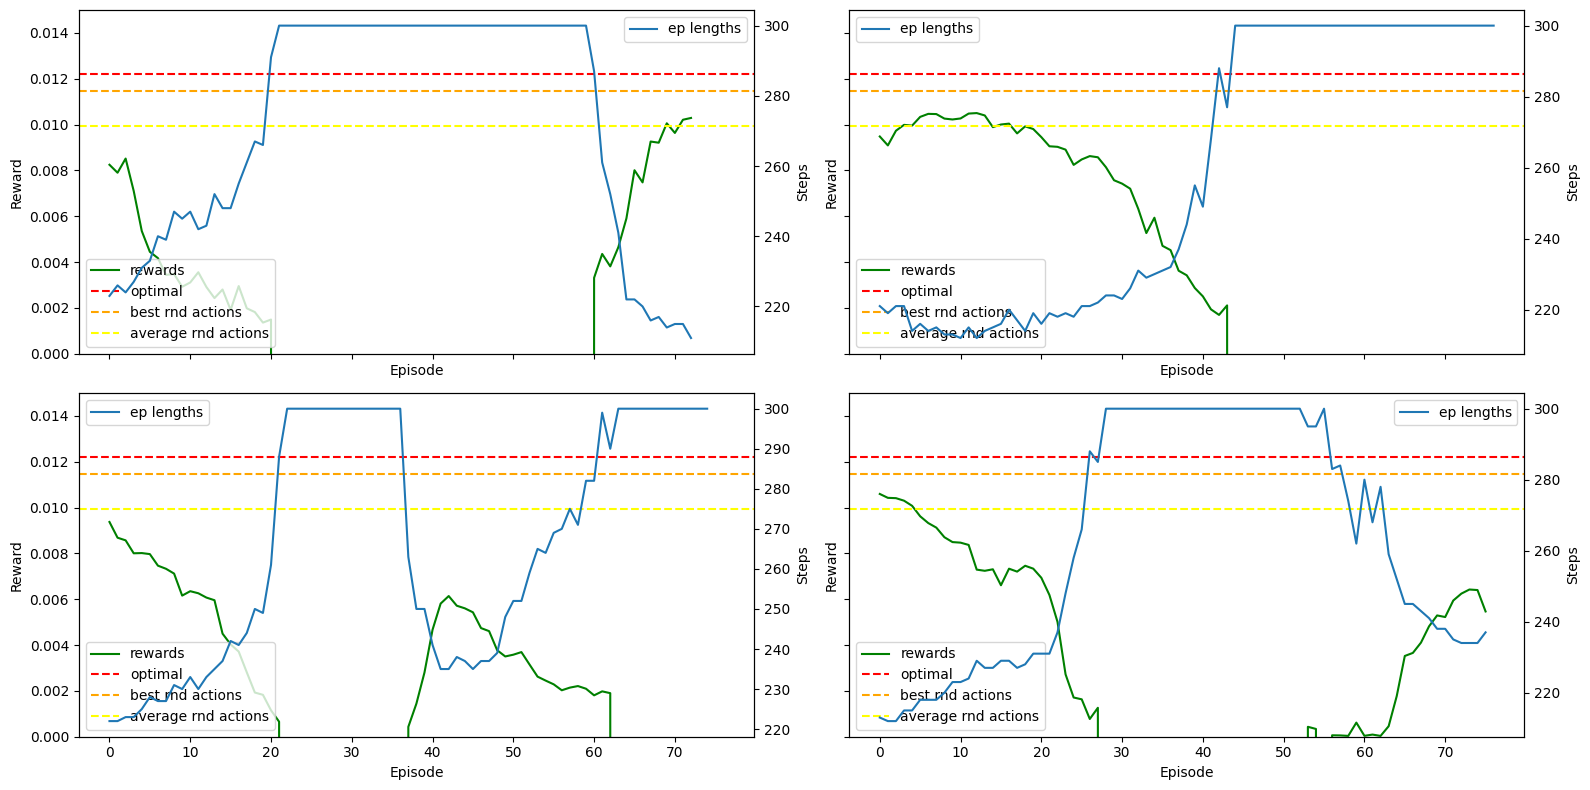

In [15]:
plot_reward_trends(train_logs_ddpg['episode'])

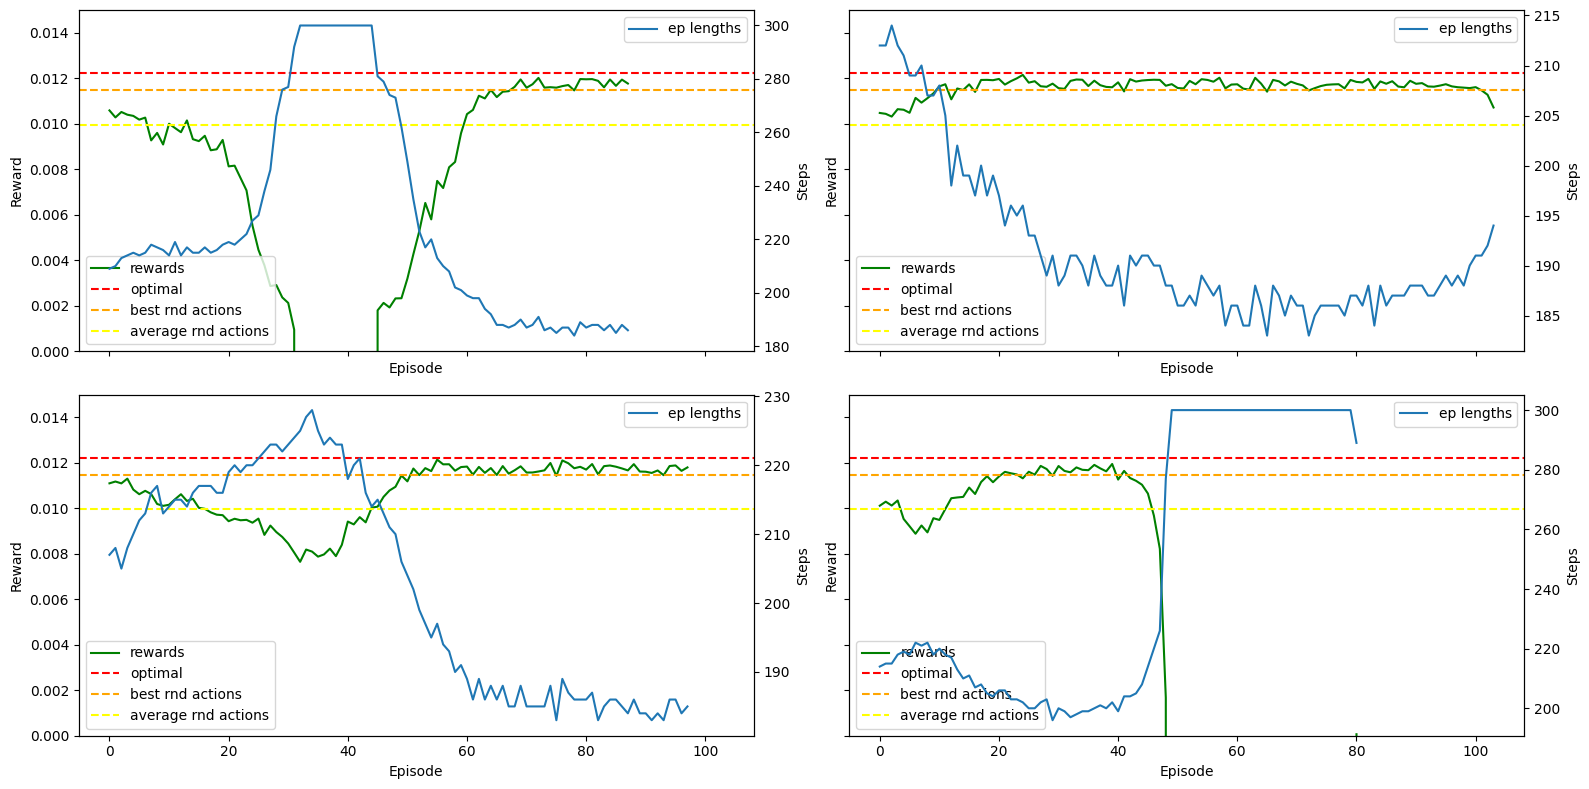

In [16]:
plot_reward_trends(train_logs_ddpg['step_wise'])

Use the following cell to test your agent on the env using deterministic actions

In [17]:
test_agent(train_logs_ddpg['episode'])

 52%|████████████████████████████████████████▊                                     | 209/400 [00:00<00:00, 3098.57it/s]


Reward during test (0): 0.010899671161883395


 75%|██████████████████████████████████████████████████████████▎                   | 299/400 [00:00<00:00, 2727.07it/s]


Reward during test (1): -1.0


 75%|██████████████████████████████████████████████████████████▎                   | 299/400 [00:00<00:00, 3547.01it/s]


Reward during test (2): -1.0


 59%|█████████████████████████████████████████████▊                                | 235/400 [00:00<00:00, 3105.03it/s]

Reward during test (3): 0.005762636309657454
Optimal control: 0.0122


In [18]:
test_agent(train_logs_ddpg['step_wise'])

 46%|████████████████████████████████████▎                                         | 186/400 [00:00<00:00, 3423.29it/s]


Reward during test (0): 0.011931160301551502


 48%|█████████████████████████████████████▊                                        | 194/400 [00:00<00:00, 2619.36it/s]


Reward during test (1): 0.010486889700480395


 46%|███████████████████████████████████▋                                          | 183/400 [00:00<00:00, 3938.50it/s]


Reward during test (2): 0.011804041234410256


 65%|██████████████████████████████████████████████████▋                           | 260/400 [00:00<00:00, 2789.32it/s]

Reward during test (3): 0.0022620704489462184
Optimal control: 0.0122


### Demo: StableBaselines3 usage

Alternatively, you can use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the DDPG algorithm as utilized by stable-baselines3 is showcased.

Note that in stable baselines the deterministic actor/policy is named $\pi$ and not $\mu$ (as in the lecture).

In [19]:
total_timesteps = int(20e3)


class Pbar(BaseCallback):
    def __init__(self):
        super().__init__()
        self.pbar = tqdm(desc='Training', total=total_timesteps, position=0, leave=True)

    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        pass

    def _on_step(self) -> bool:
        self.pbar.update()
        return True
    
    def _on_training_end(self) -> None:
        """This event is triggered before exiting the `learn()` method."""
        print("")
    
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[8], vf=[8])])

repeats = 4
logs = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv(render_mode=None))
    
    #noise_var = 4
    #noise_theta = 25  # stiffness of OU
    #action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), theta=noise_theta * np.ones(n_actions),
    #                                        sigma=noise_var * np.ones(n_actions))
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[8] * 1, qf=[8] * 1))
    model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, batch_size=256, device='cpu',
             learning_rate=1e-4, gamma=0.999, learning_starts=500)
    model.learn(total_timesteps=total_timesteps, callback=Pbar())
    logs['envs'] += [env]
    logs['models'] += [model]

Training:  99%|████████████████████████████████████████████████████████████████▋| 19897/20000 [01:25<00:00, 231.60it/s]

Training: 20071it [01:25, 234.25it/s]                                                                                  


Training: 20003it [01:28, 225.54it/s]                                                                                  


Training: 100%|████████████████████████████████████████████████████████████████▋| 19920/20000 [01:28<00:00, 196.64it/s]

Training: 20101it [01:29, 223.85it/s]                                                                                  
Training: 20080it [05:50, 57.36it/s] 


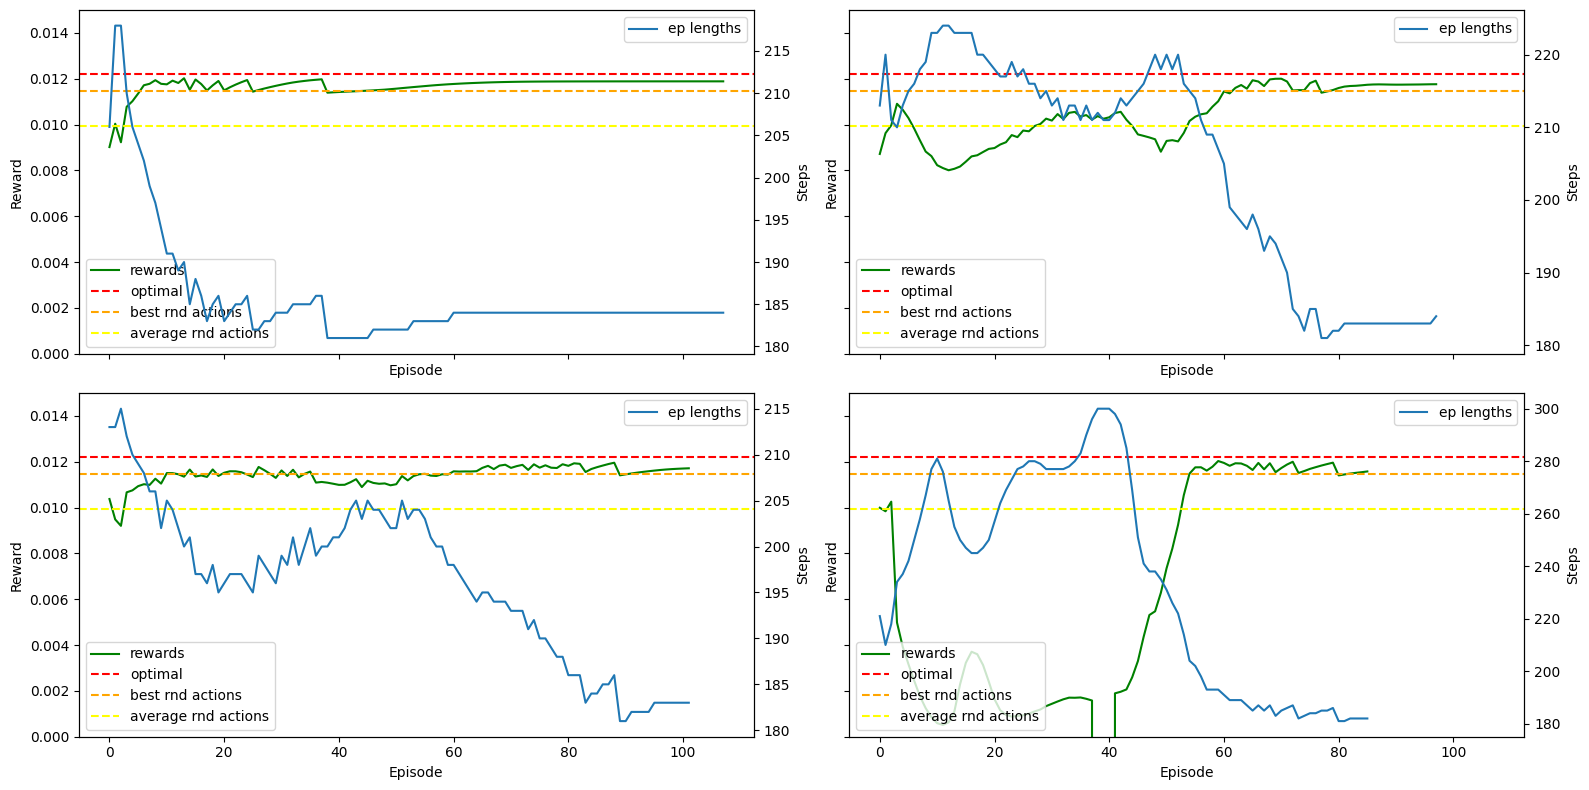

In [20]:
plot_reward_trends(logs)

Use the following cell to execute the last trained agent

In [21]:
n_episodes = 1
max_steps_per_episode = 500
tst_logs = {'rewards': []}

env.env.render_mode = "human"


for ep in range(n_episodes):
    state, info = env.reset()
    done = np.zeros(1, dtype=np.bool_)
    cum_rew = 0
    k = 0
    while not np.all(done) and k < max_steps_per_episode:
        action, _ = model.predict(state, deterministic=True) 
        state, reward, truncated, terminated, info = env.step(action)
        done = truncated or terminated
        cum_rew += reward
        k += 1

    tst_logs['rewards'].append(cum_rew)
rewards = np.array(tst_logs['rewards']).ravel()
env.close()

## 2) PPO

The [original paper from 2017](https://arxiv.org/abs/1707.06347) for the PPO came up with an idea to combine A3C (having multiple workers) and TRPO (using a trust region to improve the actor).
The PPO algorithm achieves this by clipping gradients in order to ensure that the new policy is not too far away from the old one.

In contrast to DDPG, PPO is an on-policy algorithm. In order to still apply mini-batch training, there is a so-called roll-out-buffer that is filled up with the current policy, on whose base a gradient ascent update would be done.

There are two variants on the PPO algorithm, from which we will implement the clip variant.

The actor (policy) update is computed according to (```actor_loss```)

\begin{align}
\theta_{k+1} &= \arg \max_{\theta} \underset{\langle x,u \rangle \sim \pi_{\theta_k}}{{\mathbb E}}\left[\mathcal L(X,U,\theta_k, \theta)\right], \\
\mathcal L(x,u,\theta_k,\theta) &= \min\left(
\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}  A^{\pi_{\theta_k}}(x,u), \;\;
\text{clip}\left(\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(x, u)
\right),
\end{align}
where the expectation operator denotes the empirical average across the roll-out-buffer, $\theta$ the possible next weights of the actor, $\epsilon$ denotes the threshold within the next update is allowed, and $\mathcal L$ the long-term return.

On the opposite side, the critic's weights $\omega_k$ are updated through the plain stochastic mini-batch gradient descent on the mean squared error $\mathcal C$ between immediately seen rewards $r_{k+1}$ and corresponding estimated value $v_{w_k}(x_k)$ across the roll-out-buffer (```critic_loss```):
\begin{align}
w_{k+1} &\leftarrow \omega_k - \alpha \nabla\mathcal C(X,R_{k+1},\omega_k), \\
\mathcal C(x,r_{k+1}, \omega_k) &= \left(v_{\omega_k} (x_k)- r_{k+1}\right)^2
\end{align}

### Task: Implement the PPO clip variant with PyTorch
Fill in the below code to run the PPO-clip variant on the rocket environment. Use the Algo. 13.1 from lecture 13 for guidance.

For simplicity, do not contemplate a vectorized environment for synchronous training (like in A2C or A3C).
Moreover, calculate the generalized advantage estimate with $\lambda = 1$.

In [24]:
class StochActor(nn.Module):
    """This stochastic actor learns a Gaussian distribution. While the mean value 
    is learnt by a full-fledged MLP, the standard deviation is denoted by a
    single trainable weight. With Pytorch's distribution package, probabilities 
    given a certain distribution and an action can be calculated."""
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # The standard deviation is just one trainable weight
        self.log_std = torch.nn.Parameter(
                        torch.as_tensor(
                            -.5 * np.ones(action_dim, dtype=np.float32)))
        # the mean value is estimated by a full MLP
        self.mu_net = mlp(list(state_dim) + [8] + list(action_dim), nn.Tanh, nn.Sigmoid)
        
    def _distribution(self, state):
        """Returns a gaussian distribution where mean and standard deviation are chosen in
        dependence of the current state.
        """
        return torch.distributions.normal.Normal(
                self.mu_net(state), torch.exp(self.log_std))
    
    def forward(self, state, action=None):
        """Computes the action distribtuion for the current state and the probability of an action
        in that policy.

        Args:
            state: The state for which to compute the action distribtuion
            action: An action for which to compute the log probability

        Returns:
            pi: The computed action distribution
            logp_a: The log probability for the given action in the computed distribution
        """
        pi = self._distribution(state)
        # if action is None, logp_a will be, too
        if action is None:
            logp_a = None
        else:
            logp_a = pi.log_prob(action).sum(axis=-1)
        return pi, logp_a


class RolloutBuffer:
    """The rollout buffer serves as the memory of this algorithm. Note while it looks similar to the
    replay buffer, it fullfils a very different role:

    The replay buffer (in DDPG) is filled more or less independent of the training. It just gathers 
    the data that is put into it and releases old data when there is no more space. Fetching a
    batch from this buffer just gives you a random batch of data tuples from interactions that were
    done at some point during the training.
    
    The rollout buffer (in PPO) is filled with a full episode that is then used for learning (this
    is more akin to Monte Carlo simulations from e.g. exercise 4). This means that the data batch
    from the rollout buffer is always the sequence of interactions from the last episode.
    """
    def __init__(self, size, action_dim, state_dim):
        self.action_buf = np.zeros((size, action_dim[0]), dtype=np.float32)
        self.state_buf = np.zeros((size, state_dim[0]), dtype=np.float32)
        self.rew_buf = np.zeros(size+1, dtype=np.float32)
        self.val_buf = np.zeros(size+1, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.i = 0
        self.max_size = size
        
    def push(self, state, action, reward, value, logp):
        """Append a sample to the buffer."""
        self.state_buf[self.i] = state
        self.action_buf[self.i] = action
        self.rew_buf[self.i] = reward
        self.val_buf[self.i] = value
        self.logp_buf[self.i] = logp
        self.i += 1
        
    def fetch(self, last_val=None, gamma=0.999):
        """Get all data from the rollout buffer.

        Args:
            last_val: An optional last value to add to reward and value buffers
            gamma: The discount factor
        
        Returns:
            A dictionary for state, action, rewards-to-go, advantages, and logp values.
            Entries might be of different length across multiple calls to this function as episodes
            potentially have different lengths. Rewards-to-go and advantages need to be computed from 
            rewards, values, and gamma, as outlined in https://arxiv.org/abs/1506.02438 (or as done
            in the spinning up implementation). Normalize the advantage batch by standard scaling.
        """
        if last_val is not None:
            self.rew_buf[self.i] = last_val
            self.val_buf[self.i] = last_val
        rewards = self.rew_buf[:self.i+1]
        values = self.val_buf[:self.i+1]

        # TODO: Add comments for this to be doable
        ### BEGIN SOLUTION
        
        # Advantage calculaton
        w = np.arange(rewards.size - 1)
        w = w - w[:, np.newaxis]
        w = np.triu(gamma ** w.clip(min=0)).T
        advantages = rewards[:-1] + gamma * values[1:] - values[:-1]
        advantages = (advantages.reshape(-1, 1) * w).sum(axis=0)
        
        # reward
        rewards_to_go = ((gamma*rewards[:-1]).reshape(-1, 1) * w).sum(axis=0)
        
        # normalize advantages
        advantages = (advantages - advantages.mean()) / np.std(advantages)

        ### END SOLUTION

        data =  {'state': self.state_buf[:self.i],
                 'action': self.action_buf[:self.i],
                 'rewards_to_go': rewards_to_go.copy(),  # make stride positive
                 'advantages': advantages, 
                 'logp': self.logp_buf[:self.i]}
        self.i = 0
        
        return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}


In [25]:
class PPOAgent:
    """Reference:
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/ppo.py

    This class takes care of handling the networks and almost all of the heavy lifting for the algorithm.
    """
    def __init__(self, buffer_size, env):
        self.buf = RolloutBuffer(
            buffer_size,
            action_dim=env.action_space.shape,
            state_dim=env.observation_space.shape
        )
        # use the below attributes for the actor-critic agent
        self.actor = None
        self.critic = None
        self.n_epochs = 8
        self.clip_ratio = 0.1

        # initialize actor, critic and their optimizers
        ### BEGIN SOLUTION
        
        self.actor = StochActor(action_dim=env.action_space.shape, state_dim=env.observation_space.shape)
        self.critic = mlp(list(env.observation_space.shape) + [8, 1], nn.Tanh, nn.Tanh)
        self.pi_opt = Adam(self.actor.parameters(), lr=1e-3)
        self.v_opt = Adam(self.critic.parameters(), lr=1e-3)
        
        ### END SOLUTION

    def critic_loss(self, data):
        """Compute the loss for the critic network by comparing the state value estimates
        of the critic with the rewards to go. Use the mean squared error.
        """
        state, rewards_to_go = data['state'], data['rewards_to_go']
        ### BEGIN SOLUTION

        v_loss = ((self.critic(state).squeeze(-1) - rewards_to_go)**2).mean()

        ### END SOLUTION
        return v_loss
    
    def actor_loss(self, data):
        """Compute the loss for the actor network as given on slide 15 in lecture 13."""

        state, action, advantage, logp_old = [
            data[k] for k in ('state', 'action', 'advantages', 'logp')
        ]
        
        ### BEGIN SOLUTION

        pi, logp = self.actor(state, action)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()
        
        ### END SOLUTION

        return loss_pi
    
    def learn(self, last_value=None):
        """Fetch the rollout buffer for all samples.
        Train the actor and critic for n_epochs by computing their
        losses iteratively.
        The rewards and values buffer needs a zero appended for terminal states,
        or the critic's estimate appended in case of intermediate states 
        that result from timeout. This is denoted by last_value."""
        ### BEGIN SOLUTION
        batch = self.buf.fetch(last_value)
        loss_pi_old = self.actor_loss(batch).item()
        loss_v_old = self.critic_loss(batch).item()
        
        # update policy n_epoch times
        for _ in range(self.n_epochs):
            self.pi_opt.zero_grad()
            loss_pi = self.actor_loss(batch)
            loss_pi.backward()
            self.pi_opt.step()
        
            self.v_opt.zero_grad()
            loss_v = self.critic_loss(batch)
            loss_v.backward()
            self.v_opt.step()
        
        ### END SOLUTION
    
    def policy(self, state, deterministic=False):
        """Decides on an action, given the current state. Either the mean of the
        of the policy distribution if chosen deterministically or a sample from
        that distribution.

        Args:
            state: The current state
            deterministic: Whether to choose the mean or sample from the
                distribution
        
        Returns:
            a: The chosen action as a numpy array
            v: The state value for the current state
            logp_a: The log probability of the chosen action in the policy
        """
        state = torch.as_tensor(state, dtype=torch.float32)
        with torch.no_grad():
            ### BEGIN SOLUTION

            pi = self.actor._distribution(state)
            if deterministic:
                return pi.mean.numpy()
            else:
                a = pi.sample()
            logp_a = pi.log_prob(a).sum(axis=-1)
            v = self.critic(state)
    
            ### END SOLUTION
        return a.numpy(), v.numpy(), logp_a.numpy()

In [26]:
# main training loop
tqdm(desc='Training', total=total_timesteps, position=None, leave=True)

n_episodes = 250
max_steps_per_episode = 500
train_logs_ppo_custom = {'envs': [], 'models': []}

def train_ppo(repeats):
    for rep in range(repeats):
        env = Monitor(GoddardEnv(render_mode = None))
        agent = PPOAgent(max_steps_per_episode, env)

        for ep in tqdm(range(n_episodes), desc='Training'):
            state, info = env.reset()
            done = False
            k = 0
            while not done and k < max_steps_per_episode:
                action, value, logp_a = agent.policy(state) 
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                # track experience
                agent.buf.push(state, action, reward, value, logp_a)

                state = next_state
                k += 1

            # if episode finished with done signal, the long term value should be 0
            #  for this terminal state
            if done:
                last_value = None
            else:
                _, last_value, _ = agent.policy(state)
            agent.learn(last_value)

        train_logs_ppo_custom['envs'] += [env]
        train_logs_ppo_custom['models'] += [agent]
        env.close()
        
train_ppo(4)

Training: 100%|██████████████████████████████████████████████████████████████████████| 250/250 [00:29<00:00,  8.38it/s]


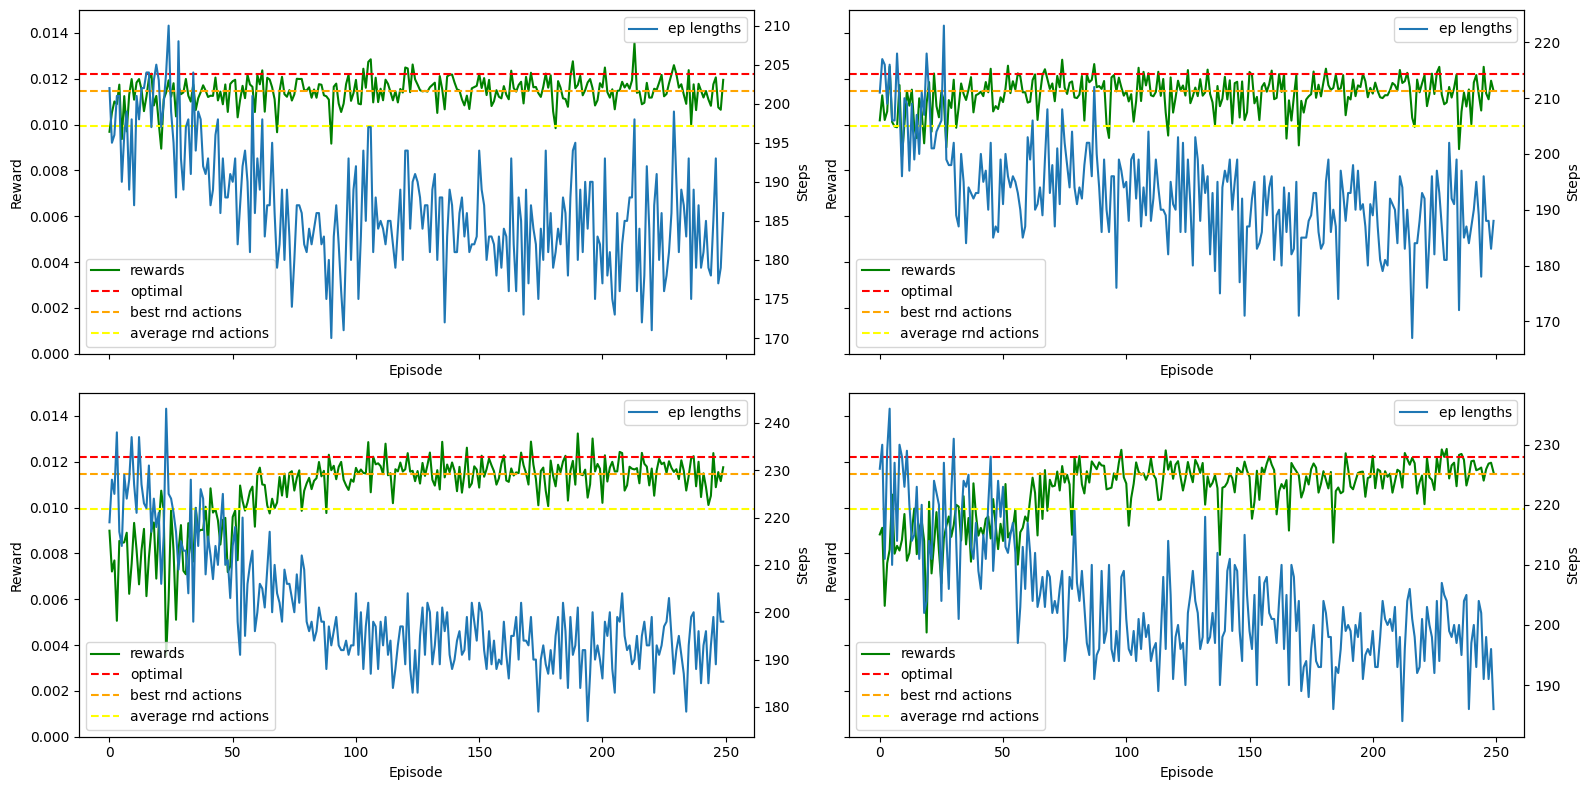

In [27]:
plot_reward_trends(train_logs_ppo_custom)

In [28]:
test_agent(train_logs_ppo_custom)

 45%|███████████████████████████████████▎                                          | 181/400 [00:00<00:00, 5797.93it/s]


Reward during test (0): 0.0114621117944389


 46%|████████████████████████████████████▎                                         | 186/400 [00:00<00:00, 2002.49it/s]


Reward during test (1): 0.011514509388474092


 49%|██████████████████████████████████████▏                                       | 196/400 [00:00<00:00, 3494.66it/s]


Reward during test (2): 0.011686858009547718


 49%|██████████████████████████████████████                                        | 195/400 [00:00<00:00, 4506.57it/s]

Reward during test (3): 0.011800865503046598
Optimal control: 0.0122


In [29]:
# more samples
train_ppo(4)

Training: 100%|██████████████████████████████████████████████████████████████████████| 250/250 [00:29<00:00,  8.61it/s]


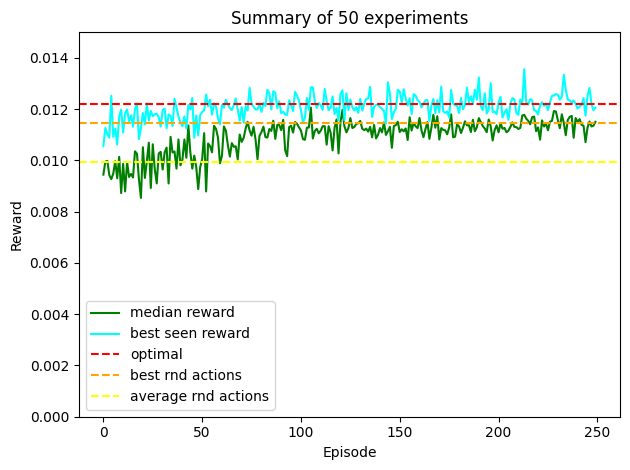

In [30]:
# plot average and standard deviation of 50 runs
repeats = len(train_logs_ppo_custom['envs'])
rewards_mat = np.asarray([_env.get_episode_rewards()[:250] for _env in train_logs_ppo_custom['envs']])
rewards_average = np.median(rewards_mat, axis=0)
rewards_std = rewards_mat.std(axis=0)

plt.figure()
ax = plt.gca()
ax.plot(rewards_average, color='green', label='median reward')
ax.plot(rewards_mat.max(axis=0), color='cyan', label='best seen reward')
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')
ax.set_ylim(0, 0.015)
ax.axhline(OPTIMAL_CONTROL, ls='--', color='red', label='optimal')
ax.axhline(RANDOM_BEST, ls='--', color='orange', label='best rnd actions')
ax.axhline(RANDOM_AVG, ls='--', color='yellow', label='average rnd actions')
ax.legend(loc='lower left')
ax.set_title('Summary of 50 experiments')
plt.tight_layout()

Very strong performance is sometimes achieved even within 10 training episodes. Here, the 'optimal' performance is based on an analytical solution using a continuous-time model (planning) which is applied to an approximate discrete-time rocket simulation. Hence, there is a systematic deviation between the model of the analytical solution and the actual simulation behavior (i.e., it is actually non-optimal w.r.t. the simplified simulation).

The low median reward curve shows that several repetitions of an algorithm are inevitable for a robust assessment.

### Demo: StableBaselines3 usage

Alternatively you can use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the PPO algorithm as utilized by stable-baselines3 is showcased.

In [33]:
class Pbar(BaseCallback):
    def __init__(self, total, n_rollout_steps):
        super().__init__()
        self.n_steps = n_rollout_steps
        self.pbar = tqdm(desc='Training', total=total_timesteps, position=0, leave=True)

    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        pass

    def _on_step(self) -> bool:
        self.pbar.update()
        return True
    
    def _on_training_end(self) -> None:
        """This event is triggered before exiting the `learn()` method."""
        print("")

    
policy_kwargs = dict(activation_fn=torch.nn.Sigmoid, net_arch=[dict(pi=[8], vf=[8])])

n_steps = 256  # an episode takes around ~250 steps
total_timesteps = n_steps*250  # steps_per_episode * episodes

repeats = 4  # repeat experiment x times to assess scatter through random init
train_logs_ppo_sb3 = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv(render_mode = None))
    model = PPO('MlpPolicy', env, n_steps=n_steps, n_epochs=8,  verbose=0, device='cpu', learning_rate=1e-3, batch_size=n_steps, policy_kwargs=policy_kwargs,
               clip_range=0.1, clip_range_vf=0.1, gamma=0.999)
    model = model.learn(total_timesteps=total_timesteps, callback=Pbar(total_timesteps, n_steps))
    train_logs_ppo_sb3['envs'] += [env]
    train_logs_ppo_sb3['models'] += [model]

Training: 100%|███████████████████████████████████████████████████████████████▊| 63862/64000 [00:43<00:00, 1380.91it/s]

Training: 100%|███████████████████████████████████████████████████████████████▉| 63878/64000 [00:46<00:00, 1428.67it/s]

Training: 100%|████████████████████████████████████████████████████████████████| 64000/64000 [00:45<00:00, 1394.61it/s]


Training: 100%|███████████████████████████████████████████████████████████████▉| 63966/64000 [00:45<00:00, 1495.39it/s]

Training: 100%|█████████████████████████████████████████████████████████████████| 64000/64000 [02:18<00:00, 462.12it/s]


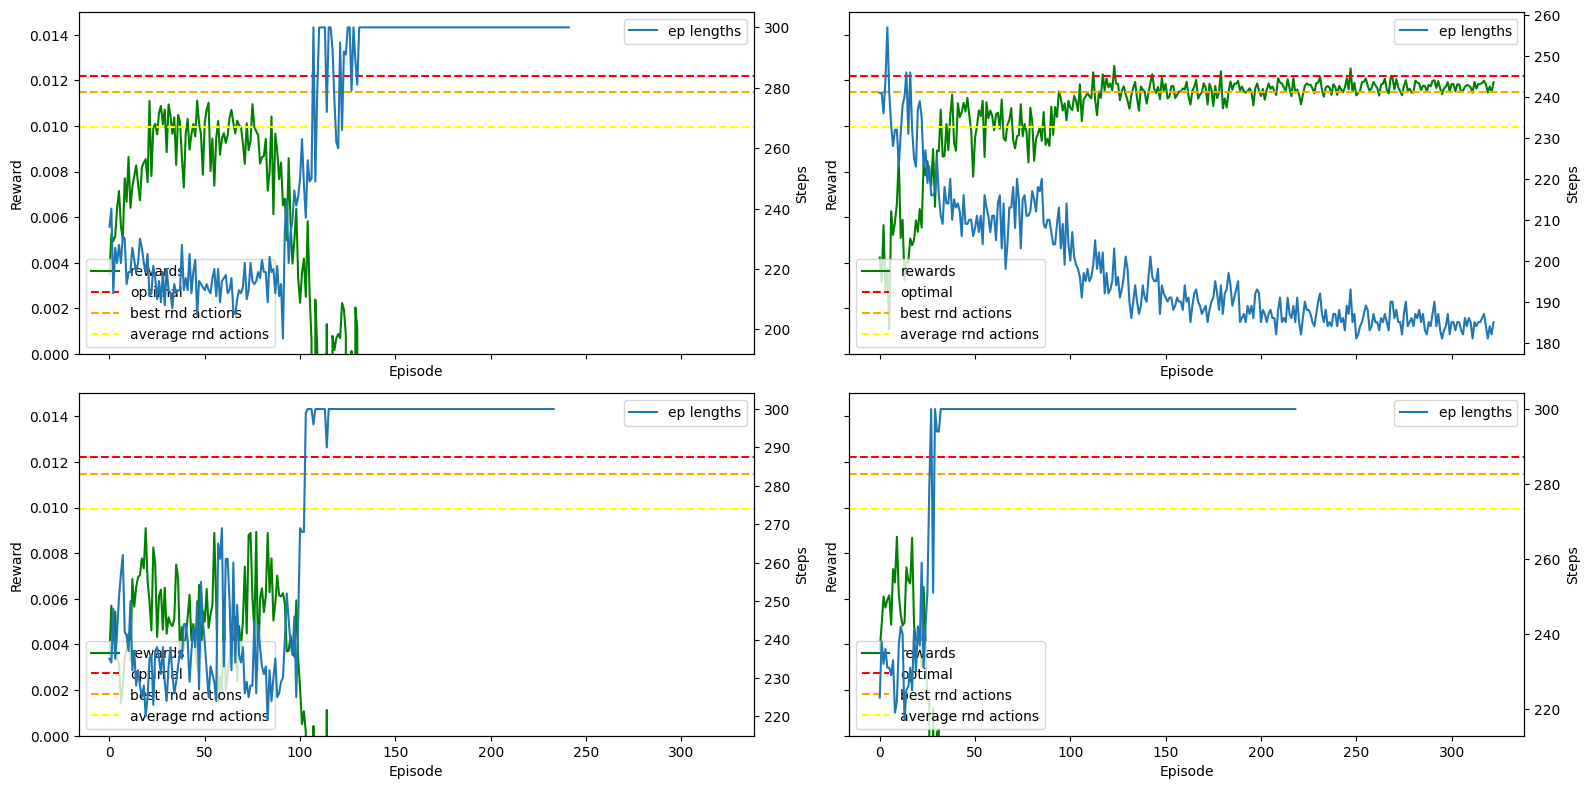

In [34]:
plot_reward_trends(train_logs_ppo_sb3)

As you can see, the chosen architecture and hyper parameters do well often, but can also fail abruptly. 
What might be the reason for these failures?